# Results Section: Fig of first look

Following these analysis, we observe that a good fit requires at least a few data points at the linear range. Thus, the worklfow for generating learning curves can be as follows. That is particularly efficient sequential processing.
1. Start with the largest training subset, and proceed to smaller subsets with a pre-defined step size.
2. Generate at least 4 learning curve points and fit power-law. Record RMSE (goodness-of-fit).
3. Starting from the 5th point (that's a heuristic), fit a power-law to the existing learning curve points. If the fit does not improve, as measured by RMSE, we terminate the workflow.

Notes:<br>
We evaluate the quality (usefulness) of fit with two measures:
1. RMSE
2. Ability to extrapolate

Question:
1. Why plots generated by LGBM and RF are so consistent across runs?? Is it because we use the same random_state??

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path

import sklearn
import numpy as np
import pandas as pd
from glob import glob

import matplotlib
import matplotlib.pyplot as plt

# Make all python scripts available in the path
sys.path.append('../')

import pp_utils
import lrn_crv_plot
%matplotlib inline

filepath = Path(os.getcwd())
print(filepath)

/vol/ml/apartin/projects/LearningCurves/notebooks


In [4]:
save_fig_path = filepath/'figs/first_look'
os.makedirs(save_fig_path, exist_ok=True)

def save_fig(save_fig_path, fname):    
    plt.savefig(save_fig_path/(fname + '.eps'), format='eps')
    plt.savefig(save_fig_path/(fname + '.png'), dpi=200)

### Get dir path of all runs

In [5]:
src = 'gdsc_on_none'
src = 'top6_on_none'

# GDSC
if src=='gdsc_on_none':
    base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_none/multi_seed_lgbm_100_trees')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_none/multi_seed_rf_100_trees')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_none/fine_grain_lgb_subset')
    
# Top6    
elif src=='top6_on_none':
    base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_none/multi_seed_lgbm_100_trees')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_none/multi_seed_rf_100_trees')  
    
# Get all run dirs
runs = glob(str(base_dir/'*'))

### Aggregate results over runs

In [6]:
scores = []
for i, r in enumerate(runs):
    # scr_tmp = pd.read_csv( Path(r)/'lrn_crv_scores.csv' )
    dpath = Path(r)/'lrn_crv_scores.csv'
    if not dpath.exists(): continue
        
    scr_tmp = pd.read_csv( dpath )
    scr_tmp.rename(columns={'fold0': 'run'+str(i+1)}, inplace=True)
    if len(scores)==0:
        scores = scr_tmp
    else:
        scores = scores.merge(scr_tmp, on=['metric', 'tr_size', 'set'])
        
run_col_names = [c for c in scores.columns if 'run' in c]

scores_mean   = scores[run_col_names].mean(axis=1)
scores_median = scores[run_col_names].median(axis=1)
scores_std    = scores[run_col_names].std(axis=1)

scores.insert(loc=3, column='mean', value=scores_mean)
scores.insert(loc=3, column='median', value=scores_median)
scores.insert(loc=3, column='std', value=scores_std)
print(len(np.unique(scores.tr_size)))

# display(scores[:2])
print('Training set sizes:', np.unique(scores.tr_size))

save = True
if save:
    scores.to_csv(base_dir/'all_seed_runs_scores.csv', index=False)

18
Training set sizes: [     2      4      8     16     32     64    128    256    512   1024
   2048   4096   8192  16384  32768  65536 131072 213015]


In [7]:
scores_te = scores[(scores.metric=='mean_absolute_error') & (scores.set=='te')].reset_index(drop=True).iloc[:, :6]
scores_te.to_csv(base_dir/'scores.csv', index=False)

In [14]:
scores_te = scores_te[1:].reset_index(drop=True)

# LC on lin-lin scale
Generated using GBDT for multiple data shuffles of GDSC.

In [8]:
figsize = (6, 4.5)
metric_name = 'mean_absolute_error'
tr_set = 'te'

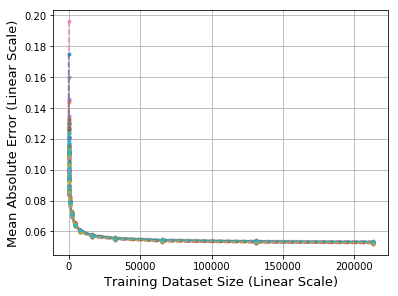

In [9]:
plot_args = {'tr_set': tr_set, 'metric_name': metric_name, 'figsize': figsize, 'xtick_scale': 'linear', 'ytick_scale': 'linear'}
x_min_id=0

ax = pp_utils.plot_lc_multi_runs( runs, shard_min_idx=x_min_id, **plot_args );
# plt.savefig(save_fig_path/f'{src}_all_runs_linlin_scale.png')
save_fig(save_fig_path, fname=f'{src}_all_runs_linlin')

# LC on log-log scale
Generated using GBDT for multiple data shuffles of GDSC.

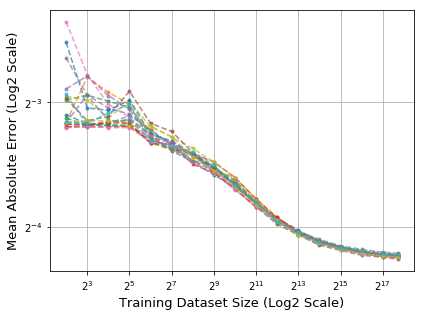

In [11]:
plot_args = {'tr_set': tr_set, 'metric_name': metric_name, 'figsize': figsize, 'xtick_scale': 'log2', 'ytick_scale': 'log2'}
x_min_id=0

ax = pp_utils.plot_lc_multi_runs( runs, shard_min_idx=x_min_id, **plot_args );
plt.tight_layout()
# plt.savefig(save_fig_path/f'{src}_all_runs_loglog_scale.png')
save_fig(save_fig_path, fname=f'{src}_all_runs_loglog')

# LC Median and STD across shuffles

In [12]:
figsize = (6, 4.5)
# figsize = (10, 8)
xtick_scale, ytick_scale = 'log2', 'log2'

plot_args = {'metric_name': metric_name, 'xtick_scale': xtick_scale, 'ytick_scale': xtick_scale, 'figsize': figsize}

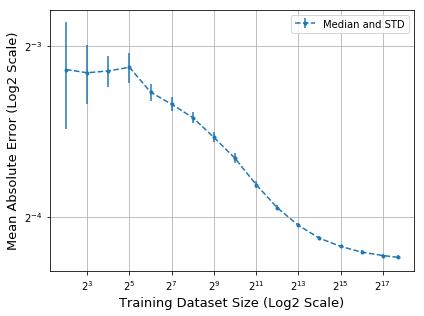

In [13]:
scores_te = scores[ (scores['metric']==metric_name) & (scores['set']=='te') ].reset_index(drop=True)
x_min_id=0
y_col_name = 'median'

ax = None
ax = lrn_crv_plot.plot_lrn_crv_new(
        x=scores_te['tr_size'][x_min_id:], y=scores_te[y_col_name][x_min_id:], yerr=scores_te['std'][x_min_id:],
        ax=ax, ls='--', marker='.', alpha=1,
        **plot_args, label='Median and STD')

ax.legend(frameon=True, fontsize=10, loc='best');
plt.tight_layout()
# plt.savefig(save_fig_path/f'{src}_agg_median_std.png')
save_fig(save_fig_path, fname=f'{src}_avg_median_std')

# Power-law fit to all LC data

GOF: {'rmse': 0.004804492205894444, 'mae': 0.004195830524872815}


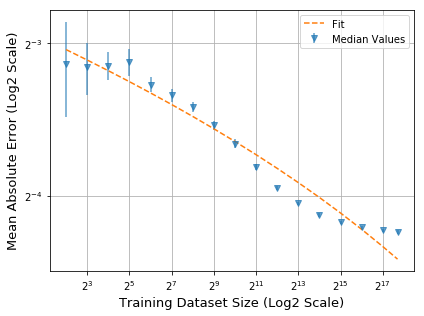

In [19]:
x_min_id=0
y_col_name = 'median'

ax = None
ax = lrn_crv_plot.plot_lrn_crv_new(
        x=scores_te['tr_size'][x_min_id:], y=scores_te[y_col_name][x_min_id:], yerr=scores_te['std'][x_min_id:],
        ax=ax, ls='', marker='v', alpha=0.7,
        **plot_args, label='Median Values')

shard_min_idx = 0
ax, _, gof = lrn_crv_plot.plot_lrn_crv_power_law(
        x=scores_te['tr_size'][shard_min_idx:], y=scores_te[y_col_name][shard_min_idx:],
        **plot_args, plot_raw=False, ax=ax, alpha=1);

ax.legend(frameon=True, fontsize=10, loc='best')
plt.tight_layout()
# plt.savefig(save_fig_path/f'{src}_agg_median_std_fit_all_points.png')
save_fig(save_fig_path, fname=f'{src}_agg_median_std_fit_all')

print('GOF:', gof)

# Power-law fit to a subset LC data

GOF: {'rmse': 8.884070412689513e-05, 'mae': 8.189525816631581e-05}


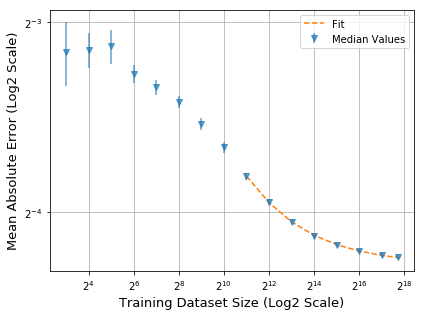

In [20]:
tot_pnts = len(scores_te['tr_size'])
n_pnts_fit = 8 # Number of points to use for curve fitting starting from the largest size
y_col_name = 'median'

ax = None

x_min_id = 1
ax = lrn_crv_plot.plot_lrn_crv_new(
        x=scores_te['tr_size'][x_min_id:], y=scores_te[y_col_name][x_min_id:], yerr=scores_te['std'][x_min_id:],
        ax=ax, ls='', marker='v', alpha=0.7,
        **plot_args, label='Median Values')

shard_min_idx = 0 if tot_pnts < n_pnts_fit else tot_pnts - n_pnts_fit

ax, _, gof = lrn_crv_plot.plot_lrn_crv_power_law(
        x=scores_te['tr_size'][shard_min_idx:], y=scores_te[y_col_name][shard_min_idx:],
        **plot_args, plot_raw=False, ax=ax, alpha=1 );

ax.legend(frameon=True, fontsize=10, loc='best')
plt.tight_layout()
# plt.savefig(save_fig_path/f'{src}_agg_median_std_fit_subset_points.png')
save_fig(save_fig_path, fname=f'{src}_agg_median_std_fit_subset')

print('GOF:', gof)

# MAE as a function of LC points

The workflow is to go backwards. We fit a power-law after every time we compute score for consecutive (smaller) shard. Stop when quality of fit decreases.

tot_pnts 17


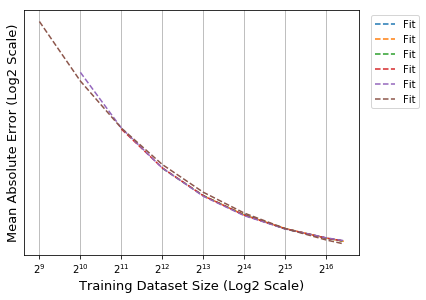

In [31]:
tot_pnts = len(scores_te['tr_size'])
print('tot_pnts', tot_pnts)
# min_points = 3 # 3 points doesn't work
min_pnts_fit = 4
max_pnts_fit = 9
# max_pnts_fit = tot_pnts

p_arr = []
# rmse_arr = []
gof_arr = []
prm_arr = []
ax = None
for n_pnts_fit in range(min_pnts_fit, max_pnts_fit+1):
# for shard_min_idx in range(tot_points - min_points + 1):
    # n_points = tot_points - shard_min_idx
    shard_min_idx = tot_pnts - n_pnts_fit
    
    ax, prm, gof = lrn_crv_plot.plot_lrn_crv_power_law(
            x=scores_te['tr_size'][shard_min_idx:], y=scores_te['median'][shard_min_idx:],
            **plot_args, ax=ax, plot_raw=False, label=str(n_pnts_fit) );
    
    prm_arr.append(prm)
    gof_arr.append(gof)
    p_arr.append(n_pnts_fit)
    
# ax.legend(frameon=True, fontsize=10, loc='best');

# idx = np.array(rmse_arr).argmin()
# p_arr[idx]

In [32]:
prm_df = pd.DataFrame(prm_arr)
gof_df = pd.DataFrame(gof_arr)
n_pnts_df = pd.DataFrame({'n_pnts': p_arr})
dd = pd.concat([n_pnts_df, gof_df, prm_df], axis=1)

display(dd.sort_values('mae'))

,n_pnts,mae,rmse,alpha,beta,gamma
0,4,1.081598e-07,1.264139e-07,4.124380,-0.697927,0.068243
3,7,3.483427e-05,4.461233e-05,1.276733,-0.568142,0.067716
2,6,3.517281e-05,4.192842e-05,1.129097,-0.552468,0.067587
1,5,3.783036e-05,4.341685e-05,0.956741,-0.532353,0.067441
4,8,6.352144e-05,7.953847e-05,1.547220,-0.594106,0.067959
5,9,4.435710e-04,5.984622e-04,0.676031,-0.472859,0.066259


The plot below can go to a table!

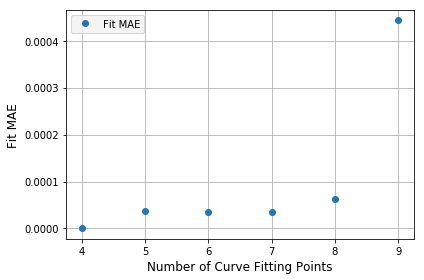

In [33]:
plot_beta = False

fig, ax1 = plt.subplots()

# Plot metrics
alpha = 0.6
linewidth = 1
fontsize = 12
lns1 = ax1.plot(dd.n_pnts, dd.mae, marker='o', ls='', label='Fit MAE');
ax1.set_xlabel('Number of Curve Fitting Points', fontsize=fontsize)
ax1.set_ylabel('Fit MAE', fontsize=fontsize)
ax1.tick_params('y', colors='k')

leg = lns1

if plot_beta:
    ax2 = ax1.twinx()
    lns2 = ax2.plot(dd.n_pnts, dd.beta, color='m', marker='*', ls='', label='Fit Parameter $b$')
    ax2.set_ylabel('Fit Parameter $b$ in $am^{b} + c$', color='k', fontsize=fontsize)
    ax2.tick_params('y', colors='k')
    leg.append(lns2)
        
ax1.grid(True)

# leg = lns1 + lns2
labs = [l.get_label() for l in leg]
legend = ax1.legend(leg, labs, loc=0)
frame = legend.get_frame()
frame.set_facecolor('0.95')
plt.tight_layout()

# plt.savefig(save_fig_path/f'{src}_mae_prm_b_num_points.png')
save_fig(save_fig_path, fname=f'{src}_mae_prm_b_num_points')